In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn
%matplotlib inline
sns.set_style("dark")
from pandas.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
import datetime as dt
import matplotlib.dates as mdates

/Users/samuelkim/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Instructions

__First__: Go out and find a dataset of interest. It could be from one of our recommended resources, some other aggregation, or scraped yourself. Just make sure it has lots of variables in it, including an outcome of interest to you.

__Second__: Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.

__Third__: Model your outcome of interest. You should try several different approaches and really work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. Make sure to think about explanatory versus predictive power and experiment with both.

A specified research question your model addresses:

-How you chose your model specification and what alternatives you compared it to

-The practical uses of your model for an audience of interest

-Any weak points or shortcomings of your model

## Dataset

The dataset file "crypto-markets.csv" was downloaded from [Kaggle](https://www.kaggle.com/jessevent/all-crypto-currencies), and includes "all historic open, high, low, close values for all cryptocurrencies", last updated on June 6, 2018. We will be using the available dataset to predict the closing prices of Cryptocurrencies Bitcoin, Ethereum and Ripple for the last two weeks (May 24 and June 6, 2018). As the dataset has a lot of continuous variables, we will be utilizing linear regression as well as random forest regression to determine the model most accurate for making such a prediction. 

## Preparing the Dataset / Data Cleaning

In [2]:
from subprocess import check_output
df=pd.read_csv('crypto-markets.csv',index_col='date',parse_dates=True)
df.tail()

slug symbol   name  ranknow      open      high       low  \
date                                                                     
2018-05-20  aston    ATX  Aston     1645  0.174143  0.174143  0.157184   
2018-05-21  aston    ATX  Aston     1645  0.168075  0.169099  0.165706   
2018-05-22  aston    ATX  Aston     1645  0.156766  0.157625  0.142146   
2018-05-23  aston    ATX  Aston     1645  0.147663  0.169331  0.131630   
2018-05-24  aston    ATX  Aston     1645  0.142871  0.157774  0.139641   

               close     volume  market  close_ratio  spread  
date                                                          
2018-05-20  0.167866   854900.0     0.0       0.6299    0.02  
2018-05-21  0.166054   845673.0     0.0       0.1026    0.00  
2018-05-22  0.150380   486511.0     0.0       0.5319    0.02  
2018-05-23  0.138031  1411730.0     0.0       0.1698    0.04  
2018-05-24  0.148132   821824.0     0.0       0.4683    0.02

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 785024 entries, 2013-04-28 to 2018-05-24
Data columns (total 12 columns):
slug           785024 non-null object
symbol         785024 non-null object
name           785024 non-null object
ranknow        785024 non-null int64
open           785024 non-null float64
high           785024 non-null float64
low            785024 non-null float64
close          785024 non-null float64
volume         785024 non-null float64
market         785024 non-null float64
close_ratio    785024 non-null float64
spread         785024 non-null float64
dtypes: float64(8), int64(1), object(3)
memory usage: 77.9+ MB


In [4]:
df.replace([np.inf,-np.inf],np.nan)
df.dropna()
df.columns=['Slug','Symbol','Name','Rank Now','Open','High','Low','Close','Volume','Market','Close Ratio','Spread']

In [5]:
df[df['Rank Now']<=3].groupby('Rank Now').Name.unique()

Rank Now
1     [Bitcoin]
2    [Ethereum]
3      [Ripple]
Name: Name, dtype: object

In [6]:
#Of the 13 available columns, I'm considering 6 for feature selection.
df_closeup=df[['Name','Symbol','Open','High','Low','Close','Volume','Market']]

In [7]:
BTC_data=df_closeup[df_closeup['Name']=='Bitcoin']
ETH_data=df_closeup[df_closeup['Name']=='Ethereum']
RIP_data=df_closeup[df_closeup['Name']=='Ripple']
#we now have the tables for three top-ranked cryptocurrencies

In [8]:
#opting to drop zero values in columns 'Volume' and 'Market'
BTC_data=BTC_data.iloc[243:]
RIP_data=RIP_data.iloc[145:]
ETH_data=ETH_data.iloc[1:]
ETH_data

Name Symbol        Open        High         Low       Close  \
date                                                                          
2015-08-08  Ethereum    ETH    2.790000    2.800000    0.714725    0.753325   
2015-08-09  Ethereum    ETH    0.706136    0.879810    0.629191    0.701897   
2015-08-10  Ethereum    ETH    0.713989    0.729854    0.636546    0.708448   
2015-08-11  Ethereum    ETH    0.708087    1.130000    0.663235    1.070000   
2015-08-12  Ethereum    ETH    1.060000    1.290000    0.883608    1.220000   
2015-08-13  Ethereum    ETH    1.220000    1.970000    1.170000    1.830000   
2015-08-14  Ethereum    ETH    1.810000    2.260000    1.750000    1.830000   
2015-08-15  Ethereum    ETH    1.800000    1.880000    1.570000    1.690000   
2015-08-16  Ethereum    ETH    1.680000    1.700000    1.090000    1.570000   
2015-08-17  Ethereum    ETH    1.580000    1.580000    1.190000    1.200000   
2015-08-18  Ethereum    ETH    1.220000    1.330000    1.090000    1.090000   
2015-08-19  Ethereum    ETH    1.170000    1.320000    1.170000    1.260000   
2015-08-20  Ethereum    ETH    1.250000    1.530000    1.250000    1.460000   
2015-08-21  Ethereum    ETH    1.480000    1.560000    1.350000    1.400000   
2015-08-22  Ethereum    ETH    1.400000    1.480000    1.350000    1.380000   
2015-08-23  Ethereum    ETH    1.380000    1.410000    1.300000    1.350000   
2015-08-24  Ethereum    ETH    1.350000    1.360000    1.230000    1.230000   
2015-08-25  Ethereum    ETH    1.230000    1.240000    1.130000    1.140000   
2015-08-26  Ethereum    ETH    1.130000    1.200000    1.060000    1.160000   
2015-08-27  Ethereum    ETH    1.170000    1.190000    1.140000    1.150000   
2015-08-28  Ethereum    ETH    1.150000    1.210000    1.120000    1.190000   
2015-08-29  Ethereum    ETH    1.190000    1.210000    1.150000    1.180000   
2015-08-30  Ethereum    ETH    1.180000    1.370000    1.170000    1.320000   
2015-08-31  Ethereum    ETH    1.320000    1.400000    1.200000    1.360000   
2015-09-01  Ethereum    ETH    1.350000    1.390000    1.340000    1.350000   
2015-09-02  Ethereum    ETH    1.350000    1.350000    1.260000    1.290000   
2015-09-03  Ethereum    ETH    1.300000    1.310000    1.210000    1.260000   
2015-09-04  Ethereum    ETH    1.260000    1.300000    1.240000    1.270000   
2015-09-05  Ethereum    ETH    1.280000    1.340000    1.270000    1.340000   
2015-09-06  Ethereum    ETH    1.340000    1.370000    1.290000    1.300000   
...              ...    ...         ...         ...         ...         ...   
2018-05-08  Ethereum    ETH  755.010000  774.250000  728.130000  752.860000   
2018-05-09  Ethereum    ETH  752.900000  759.530000  718.470000  752.270000   
2018-05-10  Ethereum    ETH  752.580000  766.750000  726.660000  727.280000   
2018-05-11  Ethereum    ETH  727.010000  736.980000  669.830000  679.590000   
2018-05-12  Ethereum    ETH  679.880000  691.410000  644.070000  686.050000   
2018-05-13  Ethereum    ETH  687.170000  741.310000  675.320000  733.500000   
2018-05-14  Ethereum    ETH  732.730000  742.170000  695.790000  730.550000   
2018-05-15  Ethereum    ETH  731.140000  739.050000  701.000000  708.870000   
2018-05-16  Ethereum    ETH  708.090000  710.200000  682.540000  707.050000   
2018-05-17  Ethereum    ETH  708.720000  718.830000  668.830000  672.660000   
2018-05-18  Ethereum    ETH  672.100000  695.030000  663.810000  694.370000   
2018-05-19  Ethereum    ETH  695.070000  715.580000  686.790000  696.530000   
2018-05-20  Ethereum    ETH  697.920000  723.750000  692.670000  715.370000   
2018-05-21  Ethereum    ETH  717.190000  719.280000  692.490000  699.220000   
2018-05-22  Ethereum    ETH  700.180000  700.980000  644.030000  647.740000   
2018-05-23  Ethereum    ETH  646.670000  651.640000  572.950000  583.590000   
2018-05-24  Ethereum    ETH  584.540000  610.820000  557.210000  601.750000   
2018-05-25  Ethereum    ETH  602.140000  617.190000  575.620000  5

## Exploring the Dataset

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a12179cc0>


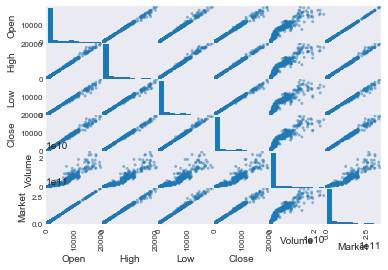

In [9]:
print(scatter_matrix(BTC_data))

            Open      High       Low     Close    Volume    Market
Open    1.000000  0.998842  0.997915  0.997329  0.948004  0.999892
High    0.998842  1.000000  0.998021  0.999110  0.950895  0.998639
Low     0.997915  0.998021  1.000000  0.998664  0.937700  0.997932
Close   0.997329  0.999110  0.998664  1.000000  0.945760  0.997205
Volume  0.948004  0.950895  0.937700  0.945760  1.000000  0.947880
Market  0.999892  0.998639  0.997932  0.997205  0.947880  1.000000


<function matplotlib.pyplot.show(*args, **kw)>

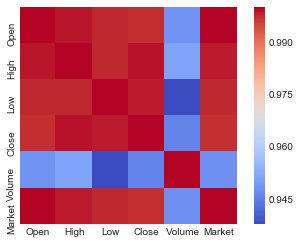

In [10]:
BTC_data_corrmat=BTC_data.corr()
print(BTC_data_corrmat)
sns.heatmap(BTC_data_corrmat,cmap="coolwarm",vmax=1,square=True)
plt.show

As expected, the heatmap and scatter matrix show high correlations for the features selected - determining features that should be dropped would be difficult. We will now visualize the prices (of all stages) of the three cryptocurrencies, with an emphasis on the price hikes for each. 

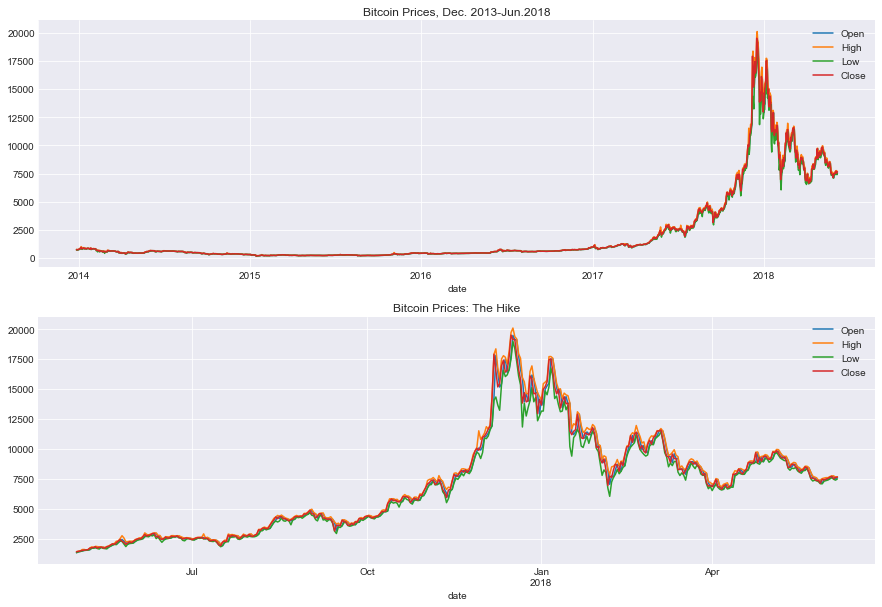

In [11]:
BTC_data_1718=df[df['Name']=='Bitcoin'].loc['2017-05-01':]
fig_year,(axy1,axy2)=plt.subplots(2,1,figsize=(15,10))
BTC_data[['Open','High','Low','Close']].plot(kind='line',title='Bitcoin Prices, Dec. 2013-Jun.2018',grid=True,ax=axy1)
BTC_data_1718[['Open','High','Low','Close']].plot(kind='line',title='Bitcoin Prices: The Hike',grid=True,ax=axy2)
plt.show()

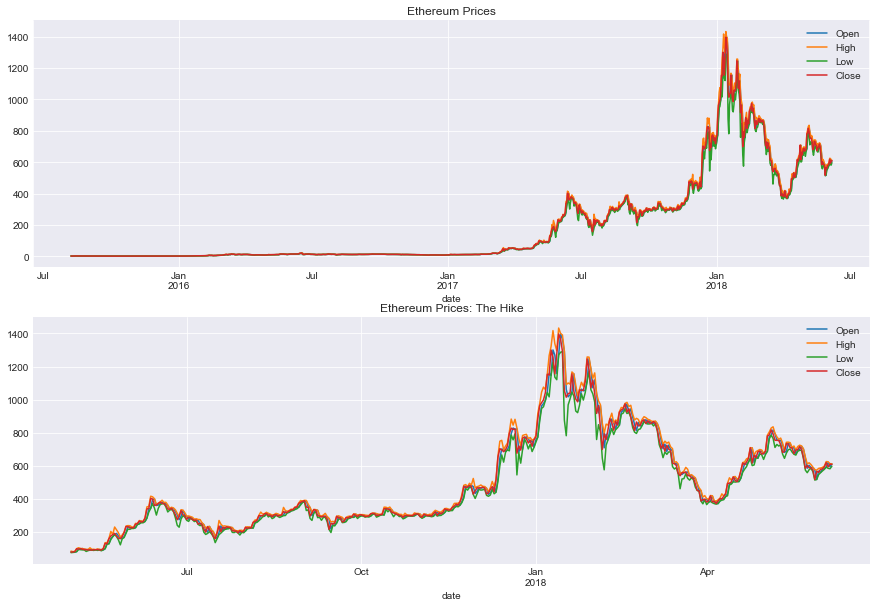

In [12]:
ETH_data_1718=df[df['Name']=='Ethereum'].loc['2017-05-01':]
fig_year,(axy3,axy4)=plt.subplots(2,1,figsize=(15,10))
ETH_data[['Open','High','Low','Close']].plot(kind='line',title='Ethereum Prices',grid=True,ax=axy3)
ETH_data_1718[['Open','High','Low','Close']].plot(kind='line',title='Ethereum Prices: The Hike',grid=True,ax=axy4)
plt.show()

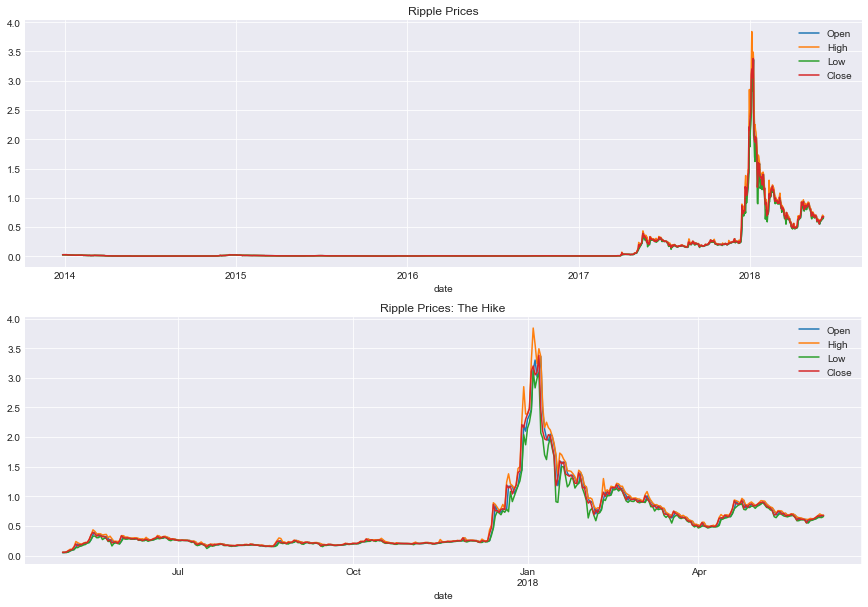

In [13]:
RIP_data_1718=df[df['Name']=='Ripple'].loc['2017-05-01':]
fig_year,(axy5,axy6)=plt.subplots(2,1,figsize=(15,10))
RIP_data[['Open','High','Low','Close']].plot(kind='line',title='Ripple Prices',grid=True,ax=axy5)
RIP_data_1718[['Open','High','Low','Close']].plot(kind='line',title='Ripple Prices: The Hike',grid=True,ax=axy6)
plt.show()

Next, we will juxtapose the close prices, market cap and transactions of all three cryptocurrencies __before__ and __after__ the hike.

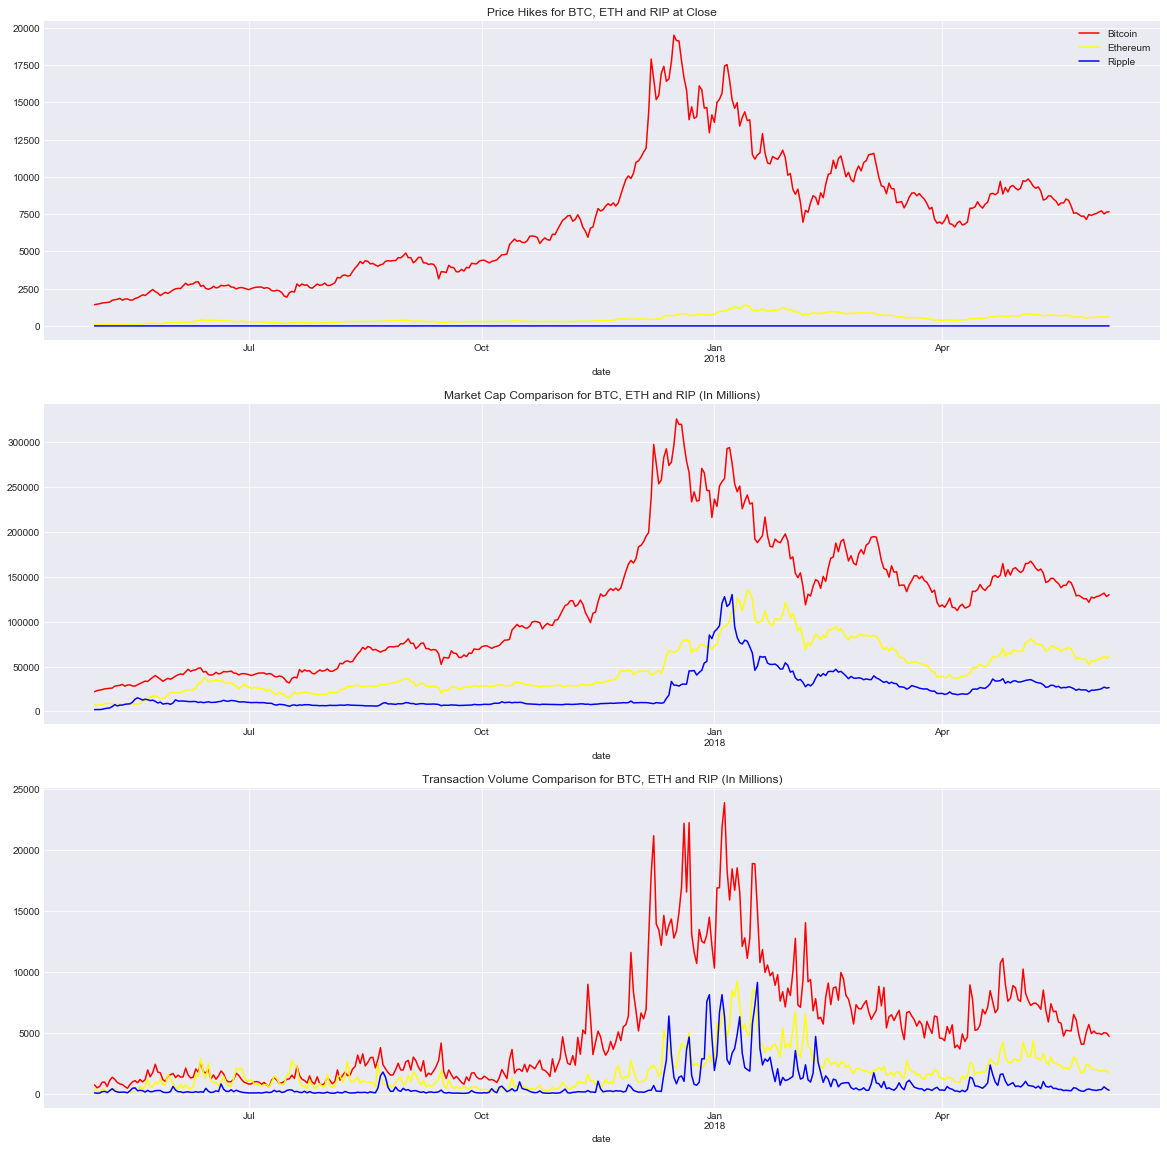

In [14]:
BTC_data_1718=BTC_data_1718.rename(columns={'Close':'Bitcoin'})
ETH_data_1718=ETH_data_1718.rename(columns={'Close':'Ethereum'})
RIP_data_1718=RIP_data_1718.rename(columns={'Close':'Ripple'})
fig_year,(axy7,axy8,axy9)=plt.subplots(3,1,figsize=(20,20))
BTC_data_1718[['Bitcoin']].plot(color='red',title='Price Hikes for BTC, ETH and RIP at Close',grid=True,ax=axy7)
ETH_data_1718[['Ethereum']].plot(color='yellow',grid=True,ax=axy7)
RIP_data_1718[['Ripple']].plot(color='blue',grid=True,ax=axy7)
(BTC_data_1718['Market']/1000000).plot(color='red',title='Market Cap Comparison for BTC, ETH and RIP (In Millions)',grid=True,ax=axy8)
(ETH_data_1718['Market']/1000000).plot(color='yellow',grid=True,ax=axy8)
(RIP_data_1718['Market']/1000000).plot(color='blue',grid=True,ax=axy8)
(BTC_data_1718['Volume']/1000000).plot(color='red',title='Transaction Volume Comparison for BTC, ETH and RIP (In Millions)',grid=True,ax=axy9)
(ETH_data_1718['Volume']/1000000).plot(color='yellow',grid=True,ax=axy9)
(RIP_data_1718['Volume']/1000000).plot(color='blue',grid=True,ax=axy9)
plt.show()

## The Models

We are going to introduce some new features/columns before testing our Linear Regression, Decision Tree and Random Forest Regression models. Based on the evaluation of our models (with observations of their respective shortcomings), we will use the __ideal__ model to forecast the closing price of BTC, ETH and RIP for the time period between May 24 and June 6 2018. 

### Linear Regression

Observing the scatter matrix and correlation matrix above, it is clear that the selected columns/features have high levels of correlation between them. This allows us to utilize multilinear regression, and predict the average of Y from X. 

In [15]:
BTC_data['Avg.']=(BTC_data['Open']+BTC_data['High']+BTC_data['Low']+BTC_data['Close'])/4
BTC_data['Projection']=BTC_data['Close'].shift(-14)
ETH_data['Avg.']=(ETH_data['Open']+ETH_data['High']+ETH_data['Low']+ETH_data['Close'])/4
ETH_data['Projection'] =ETH_data['Close'].shift(-14)
RIP_data['Avg.']=(RIP_data['Open']+RIP_data['High']+RIP_data['Low']+RIP_data['Close'])/4
RIP_data['Projection']=RIP_data['Close'].shift(-14)

#### LR for Bitcoin

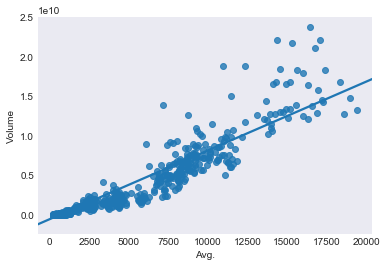

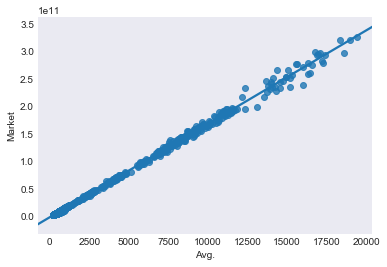

In [16]:
#Open, High, Low, Close will henceforth be abbreviated as OHLC 
#There is a linear relationship between Avg. (reflecting OHLC) and Volume as well as Market
#although the linearity with Volume appears to be weaker.
sns.regplot(BTC_data['Avg.'],BTC_data['Volume'],ci = False)
plt.show()

sns.regplot(BTC_data['Avg.'],BTC_data['Market'], ci = False)
plt.show()

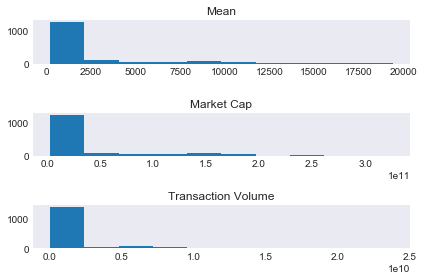

In [17]:
#Histograms for 7* features for 'X'.
#*note that OHLC histograms have also been made and returned very similar visualizations, and have been left out 
#due to redundancy.
f,(ax1,ax2,ax3)=plt.subplots(3,sharex=False, sharey=False)
plt.plot(figsize=(30,30))

ax1.hist(BTC_data['Avg.'])
ax1.set_title('Mean')
ax2.hist(BTC_data['Market'])
ax2.set_title('Market Cap')
ax3.hist(BTC_data['Volume'])
ax3.set_title('Transaction Volume')
f.tight_layout()

In [18]:
#This code will last us through all three models
#X and Y are for Bitcoin, X1 and Y1 for Ethereum, X2 and Y2 for Ripple
BTC_data.drop(['Name','Symbol'],axis=1,inplace=True)
BTC_data.dropna(inplace=True)
X=BTC_data.drop('Projection',axis=1)
X=preprocessing.scale(X)
Y=BTC_data['Projection']
ETH_data.drop(['Name','Symbol'],axis=1,inplace=True)
ETH_data.dropna(inplace=True)
X1=ETH_data.drop('Projection',axis=1)
X1=preprocessing.scale(X1)
Y1=ETH_data['Projection']
RIP_data.drop(['Name','Symbol'],axis=1,inplace=True)
RIP_data.dropna(inplace=True)
X2=RIP_data.drop('Projection',axis=1)
X2=preprocessing.scale(X2)
Y2=RIP_data['Projection']

/Users/samuelkim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/samuelkim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/samuelkim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [20]:
#back to linear regression model
regr=linear_model.LinearRegression()
regr.fit(X,Y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared: \n')
print(regr.score(X, Y))


Coefficients: 
 [-3098.69467342  5888.73488687 -3627.55589718  2423.28919847
 -1348.22766938  2535.2782378    507.86439313]

Intercept: 
 2146.8916034804224

R-squared: 

0.9235077449582338


In [21]:
X_train, X_test,Y_train,Y_test=cross_validation.train_test_split(X,Y,test_size=0.20, random_state=101)
regr.fit(X_train,Y_train)
Y_pred=regr.predict(X_test)
accuracy=regr.score(X_test,Y_test)
print('Test Accuracy:',accuracy)
scores=model_selection.cross_val_score(regr,X_train,Y_train, cv=5)
print('Cross Validation Scores:', scores)
print('Mean:', scores.mean())
print('Standard deviation:', scores.std())
RMSE_test=np.sqrt(metrics.mean_squared_error(Y_test,Y_pred))
print('RMSE Test Data:', RMSE_test)

Test Accuracy: 0.9361265099747477
Cross Validation Scores: [0.91188093 0.92315839 0.91554824 0.91359912 0.9078301 ]
Mean: 0.9144033558186863
Standard deviation: 0.005063171531091114
RMSE Test Data: 896.1700613684175


#### LR for Ethereum

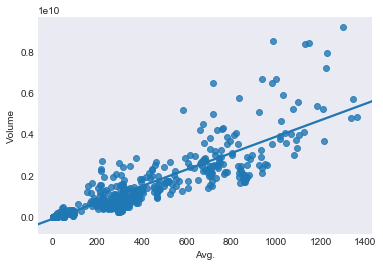

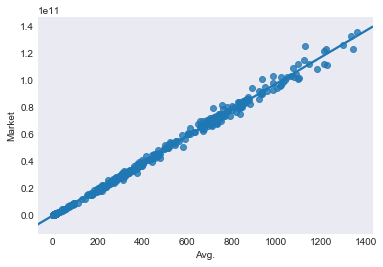

In [22]:
#We'll do the same for Ethereum
sns.regplot(ETH_data['Avg.'],ETH_data['Volume'],ci = False)
plt.show()

sns.regplot(ETH_data['Avg.'],ETH_data['Market'], ci = False)
plt.show()

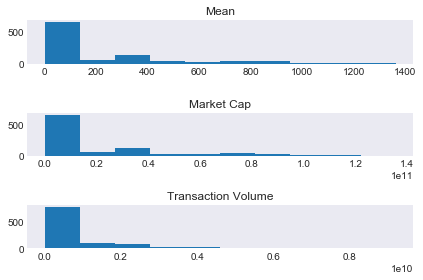

In [23]:
f,(ax1,ax2,ax3)=plt.subplots(3,sharex=False, sharey=False)
plt.plot(figsize=(30,30))

ax1.hist(ETH_data['Avg.'])
ax1.set_title('Mean')
ax2.hist(ETH_data['Market'])
ax2.set_title('Market Cap')
ax3.hist(ETH_data['Volume'])
ax3.set_title('Transaction Volume')
f.tight_layout()

In [24]:
regr=linear_model.LinearRegression()
regr.fit(X1,Y1)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared: \n')
print(regr.score(X1, Y1))


Coefficients: 
 [ 996.67900002 -308.1615177   -36.45748274  283.31481213   37.90094437
 -922.23492013  231.43982921]

Intercept: 
 199.76488799901958

R-squared: 

0.9060944927427953


In [25]:
X1_train, X1_test, Y1_train, Y1_test = cross_validation.train_test_split(X1,Y1,test_size=0.20, random_state=101)
regr.fit(X1_train,Y1_train)
Y1_pred=regr.predict(X1_test)
accuracy=regr.score(X1_test,Y1_test)
print('Test Accuracy:', accuracy)
scores=model_selection.cross_val_score(regr, X1_train, Y1_train, cv=5)
print('Cross Validation Scores:',scores)
print('Mean:', scores.mean())
print('Standard deviation:', scores.std())
RMSE_test=np.sqrt(metrics.mean_squared_error(Y1_test, Y1_pred))
print('RMSE Test Data:', RMSE_test)

Test Accuracy: 0.854040771579542
Cross Validation Scores: [0.92340308 0.92833032 0.90341253 0.90775506 0.91320579]
Mean: 0.91522135565907
Standard deviation: 0.009359938148322632
RMSE Test Data: 126.49647013072041


#### LR for Ripple

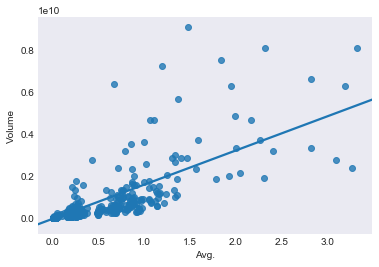

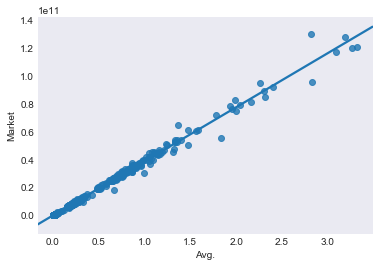

In [26]:
#And last but not least, Ripple.
sns.regplot(RIP_data['Avg.'],RIP_data['Volume'],ci = False)
plt.show()

sns.regplot(RIP_data['Avg.'],RIP_data['Market'], ci = False)
plt.show()

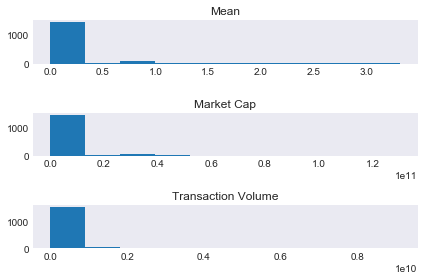

In [27]:
f,(ax1,ax2,ax3)=plt.subplots(3,sharex=False, sharey=False)
plt.plot(figsize=(30,30))

ax1.hist(RIP_data['Avg.'])
ax1.set_title('Mean')
ax2.hist(RIP_data['Market'])
ax2.set_title('Market Cap')
ax3.hist(RIP_data['Volume'])
ax3.set_title('Transaction Volume')
f.tight_layout()

In [28]:
regr=linear_model.LinearRegression()
regr.fit(X2,Y2)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared: \n')
print(regr.score(X2, Y2))


Coefficients: 
 [-0.85517087 -0.58815981 -0.33938509  0.95564375  0.05114213  1.29441713
 -0.21274891]

Intercept: 
 0.14818817029210696

R-squared: 

0.688708898066062


In [29]:
X2_train, X2_test,Y2_train,Y2_test=cross_validation.train_test_split(X2,Y2,test_size=0.20, random_state=101)
regr.fit(X2_train,Y2_train)
Y2_pred=regr.predict(X2_test)
accuracy=regr.score(X2_test,Y2_test)
print('Test Accuracy:',accuracy)
scores=model_selection.cross_val_score(regr,X2_train,Y2_train, cv=5)
print('Cross Validation Scores:', scores)
print('Mean:', scores.mean())
print('Standard deviation:', scores.std())
RMSE_test=np.sqrt(metrics.mean_squared_error(Y2_test,Y2_pred))
print('RMSE Test Data:', RMSE_test)

Test Accuracy: 0.7613471747931405
Cross Validation Scores: [0.73322841 0.50462772 0.55654608 0.29918804 0.70087367]
Mean: 0.5588927858516707
Standard deviation: 0.15553021876976117
RMSE Test Data: 0.1676321996802103


Linear Regressions for Bitcoin and Ethereum yielded desired results, shown by relatively high test accuracies and cross validation scores. However, the model failed Ripple, and this is clear based on the model's grossly inconsistent cross validation scores for the cryptocurrency. We can observe that, compared to the other two, Ripple's correlation between the OHLC mean and transaction volume is noticeably weaker, and dropping the Volume column for Ripple is an option. Still, the growth of transaction volumes for all three currencies is deemed too important to ignore. 

We will now turn to Decision Tree, specifically its regressor model, to see if it would give us a better model. 

### Decision Tree Regression

#### DTR for Bitcoin

Weak learner 0 R^2: -56.390834617702865
Weak learner 20 R^2: -0.146736518597403
Weak learner 40 R^2: -0.1951793018998209
Weak learner 60 R^2: -0.0523708036277013
Weak learner 80 R^2: -0.18209256093425363
Weak learner 100 R^2: -0.20313658048713323


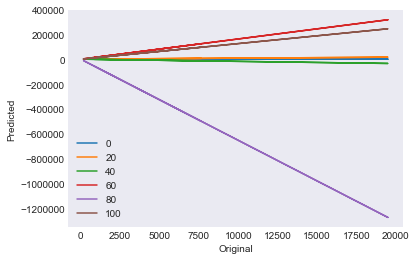

Overall R^2:
0.001081736332378851


In [30]:
from sklearn import tree 
from IPython.display import Image
import pydotplus
from pydotplus import graphviz
uniquex=Y.unique()
preds=pd.DataFrame()
labels=[]
for m in range(0, 101):
    decision_tree=tree.DecisionTreeRegressor(max_depth=6)
    decision_tree.fit(X,Y)
    pred=decision_tree.predict(X)
    preds['pred{}'.format(m)]=pred
    Y=Y-pred
    if m%20==0:
        print('Weak learner {} R^2: {}'.format(m,decision_tree.score(X,Y)))
        labels=labels+[m]
        bestpred=preds.sum(axis=1)
        plt.plot(uniquex,np.poly1d(np.polyfit(Y,bestpred,1))(uniquex))
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted=preds.sum(axis=1)
print('Overall R^2:')
print(np.corrcoef(Y,predicted)[0,1])

In [31]:
decision_tree=tree.DecisionTreeRegressor(min_samples_split=.025)
decision_tree.fit(X,Y)
pred=decision_tree.predict(X)
print('Strong learner R^2: {}'.format(decision_tree.score(X,Y))) 

Strong learner R^2: 0.32567908320288474


The R^2 value for the regressor's strong learner is noticeably smaller than what the LR model for Bitcoin provided, this means it is poor at explaining the variability around its mean. We will now try to visualize the outcome using Pydotplus:

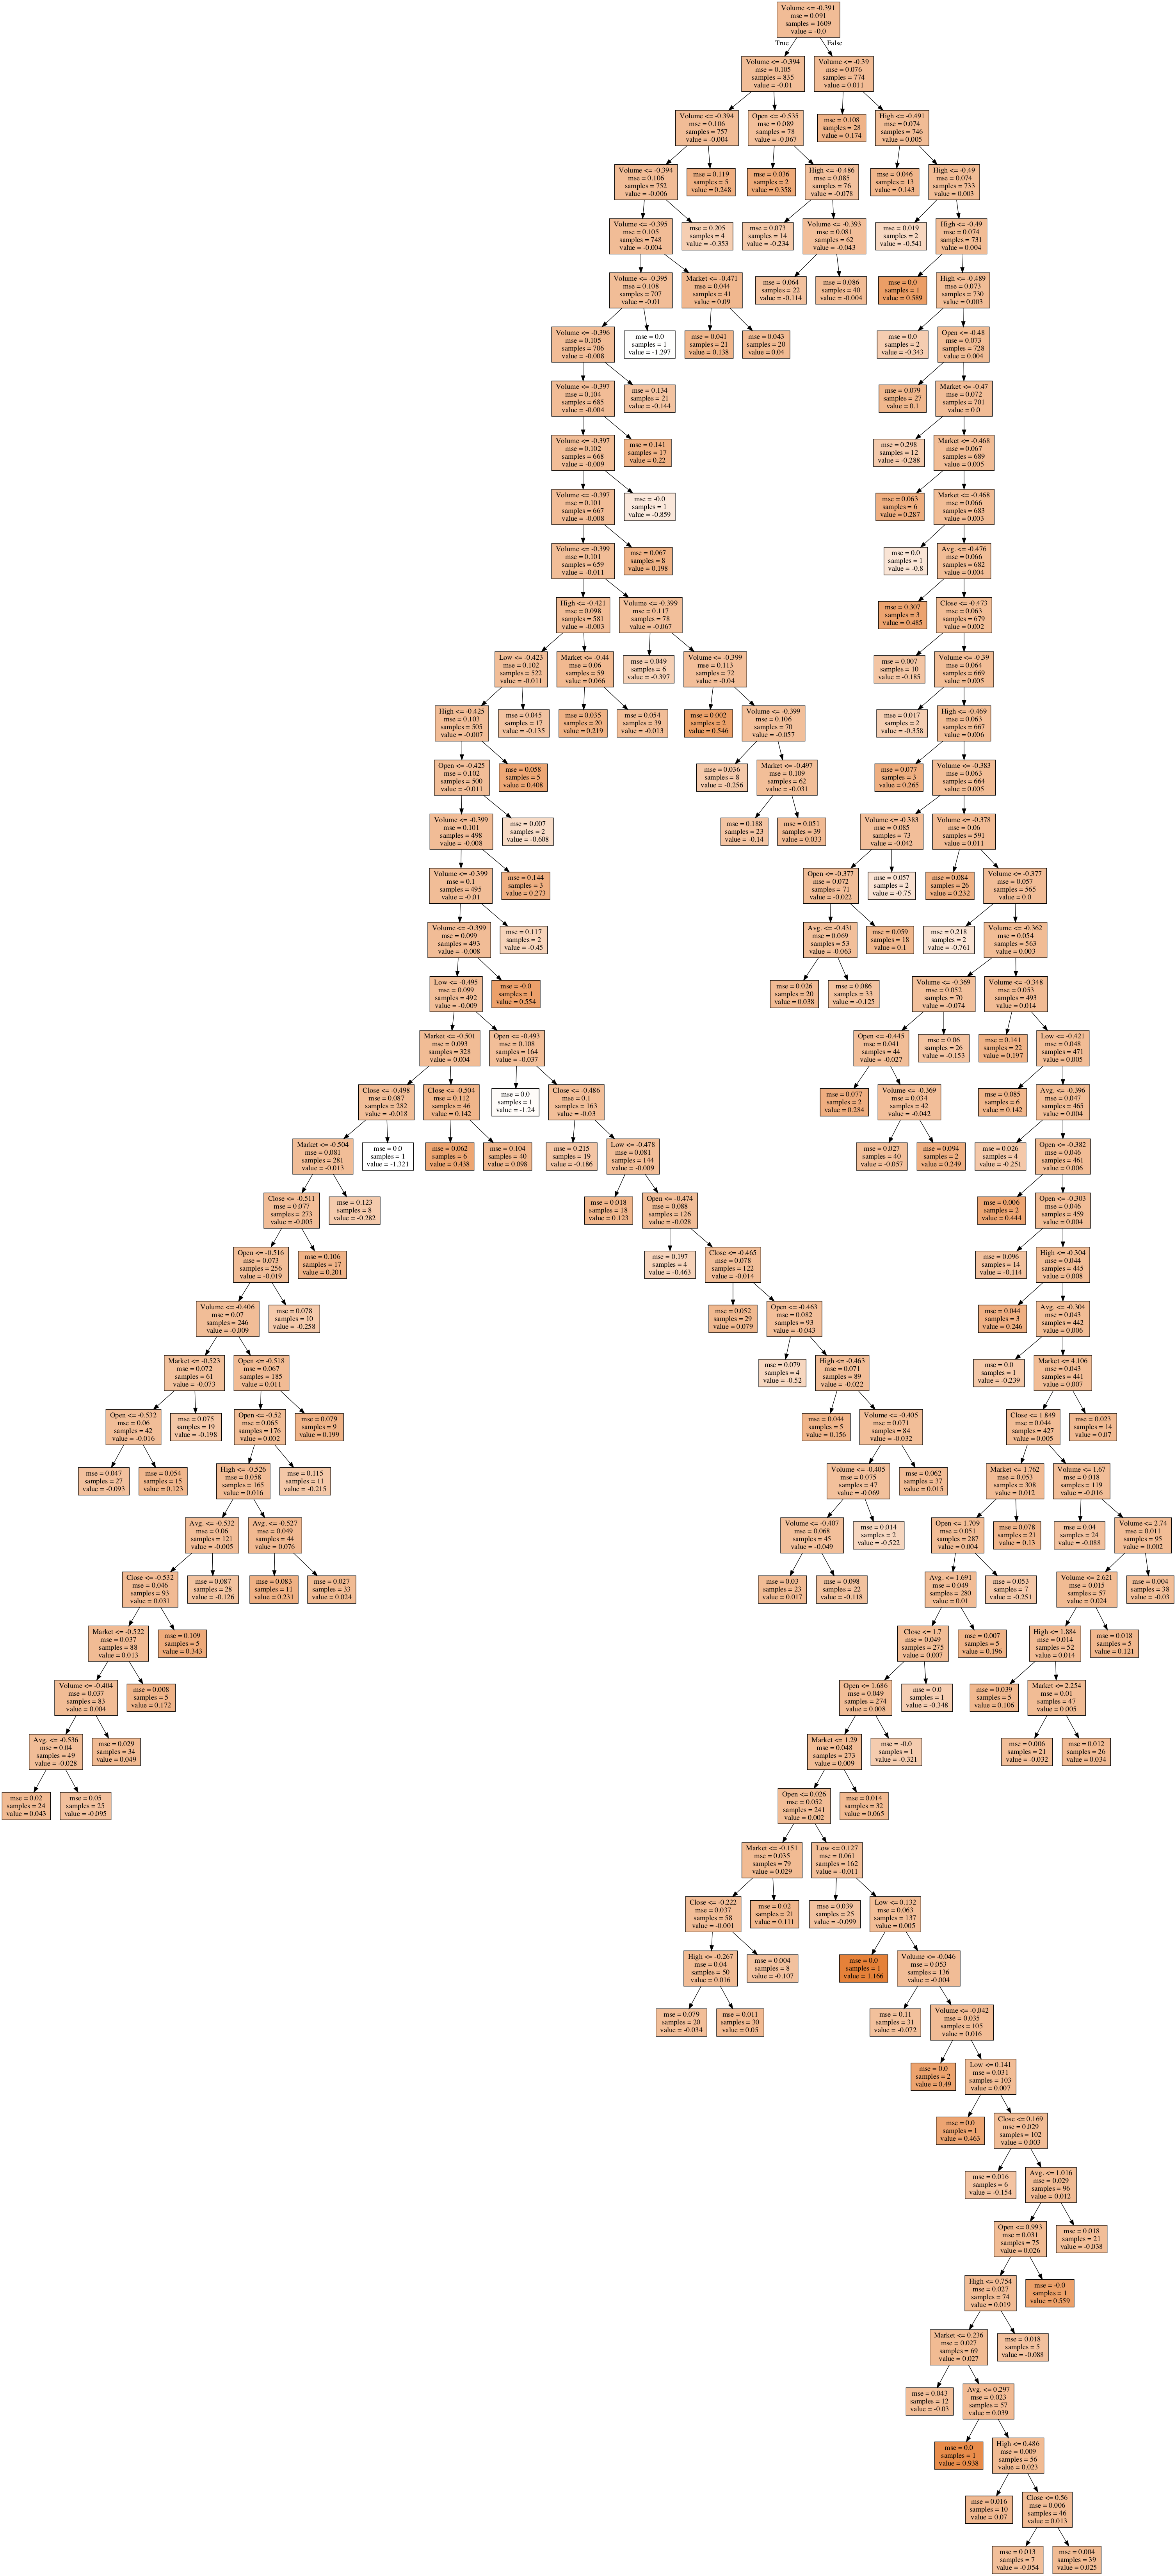

In [32]:
dot_data=tree.export_graphviz(decision_tree, out_file=None,
                                feature_names=["Open","High","Low","Close","Volume","Market","Avg."],  
                                filled=True) 
graph=pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png()) 

We will do the same for the rest: 

#### DTR for Ethereum

Weak learner 0 R^2: -64.61422779738778
Weak learner 20 R^2: -0.30048937191445835
Weak learner 40 R^2: -0.17125312212879273
Weak learner 60 R^2: -0.18050751605562465
Weak learner 80 R^2: -0.1621384310010776
Weak learner 100 R^2: -0.3006969835389004


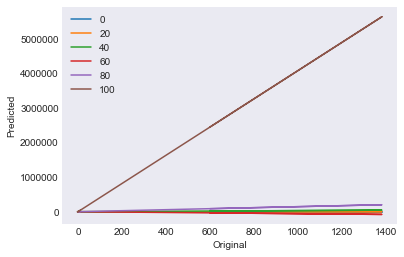

Overall R^2:
0.010742986066898714


In [37]:
uniquex1=Y1.unique()
preds1=pd.DataFrame()
labels1=[]
for m1 in range(0, 101):
    decision_tree_1=tree.DecisionTreeRegressor(max_depth=6)
    decision_tree_1.fit(X1,Y1)
    pred1=decision_tree_1.predict(X1)
    preds1['pred{}'.format(m1)]=pred1
    Y1=Y1-pred1
    if m1%20==0:
        print('Weak learner {} R^2: {}'.format(m1,decision_tree_1.score(X1,Y1)))
        labels1=labels1+[m1]
        bestpred1=preds1.sum(axis=1)
        plt.plot(uniquex1,np.poly1d(np.polyfit(Y1,bestpred1,1))(uniquex1))
plt.legend(labels1)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted1=preds1.sum(axis=1)
print('Overall R^2:')
print(np.corrcoef(Y1,predicted1)[0,1])

In [38]:
decision_tree_1=tree.DecisionTreeRegressor(min_samples_split=.025)
decision_tree_1.fit(X1,Y1)
pred1=decision_tree_1.predict(X1)
print('Strong learner R^2: {}'.format(decision_tree_1.score(X1,Y1))) 

Strong learner R^2: 0.4981237819701987


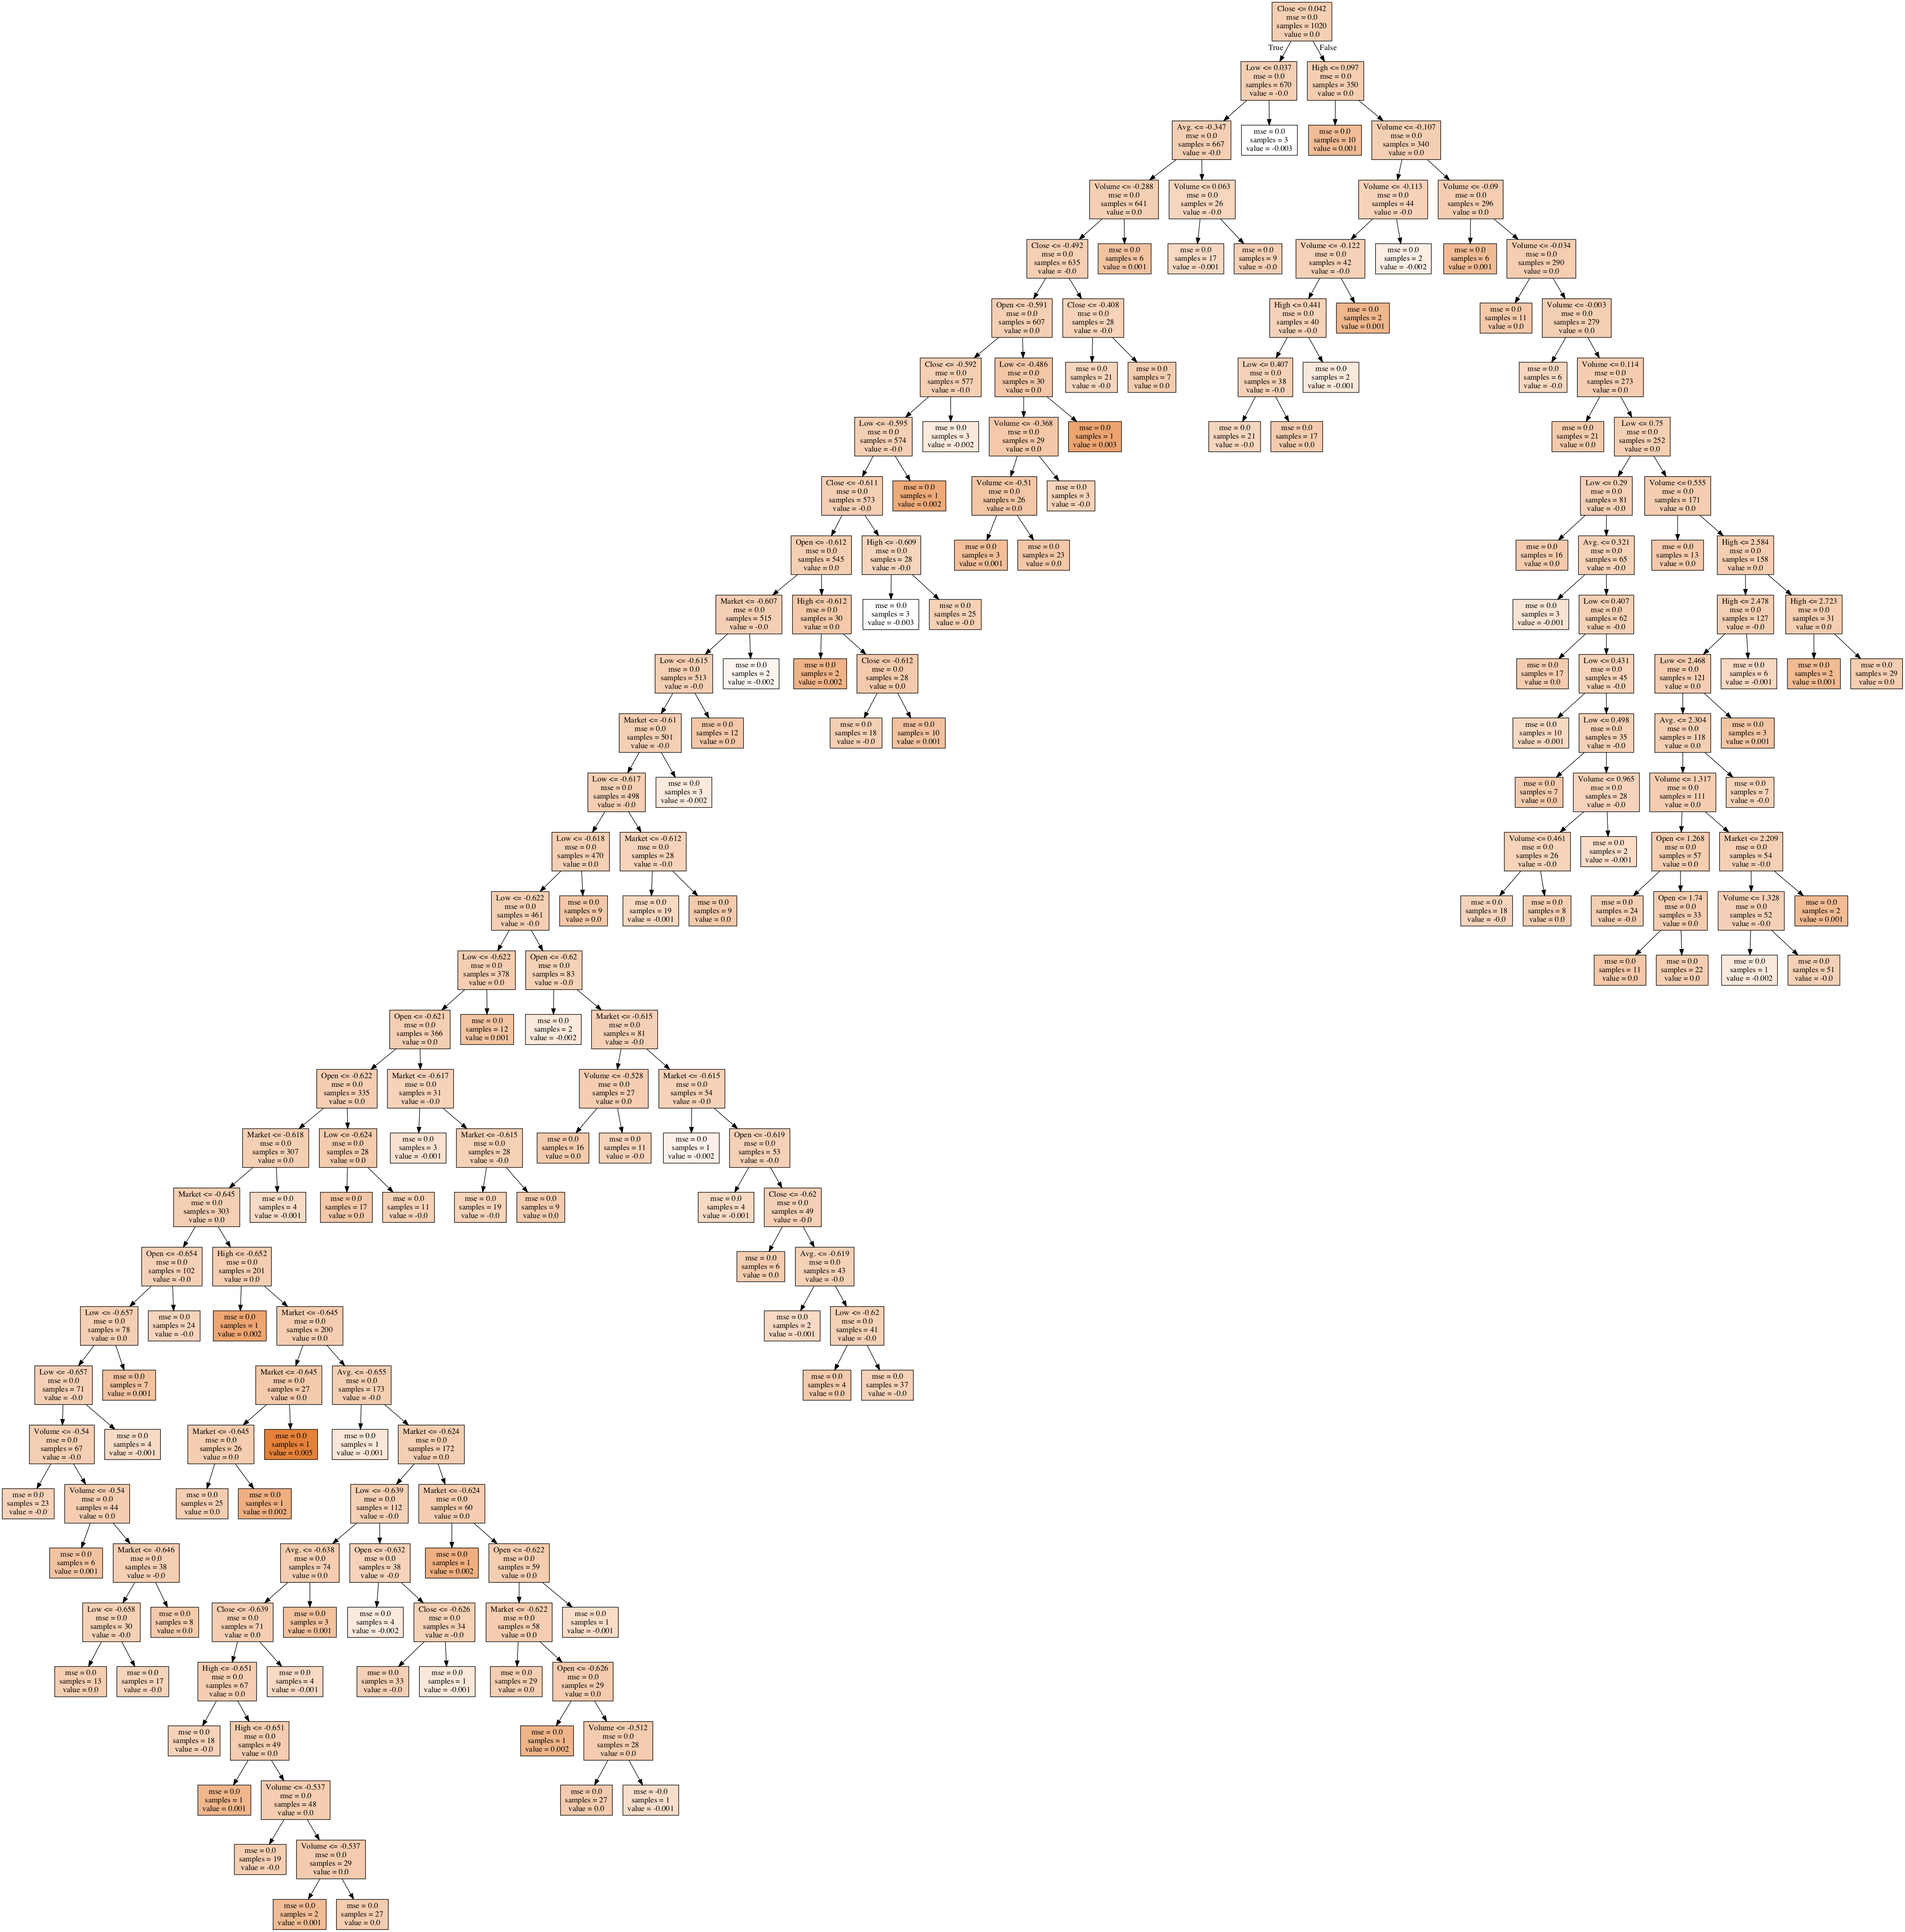

In [39]:
dot_data=tree.export_graphviz(decision_tree_1, out_file=None,
                                feature_names=["Open","High","Low","Close","Volume","Market","Avg."],  
                                filled=True) 
graph=pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png()) 

#### DTR for Ripple

Weak learner 0 R^2: -11.646421673654073
Weak learner 20 R^2: -0.33234050603598786
Weak learner 40 R^2: -0.015773229455717797
Weak learner 60 R^2: 0.0
Weak learner 80 R^2: 0.0
Weak learner 100 R^2: 0.0


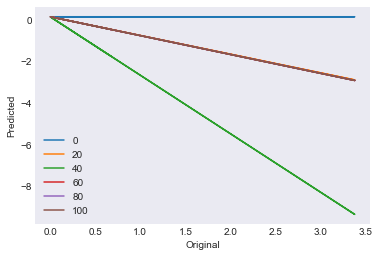

Overall R^2:
-0.0007904942400965878


In [40]:
uniquex2=Y2.unique()
preds2=pd.DataFrame()
labels2=[]
for m2 in range(0, 101):
    decision_tree_2=tree.DecisionTreeRegressor(max_depth=6)
    decision_tree_2.fit(X2,Y2)
    pred2=decision_tree_2.predict(X2)
    preds2['pred{}'.format(m2)]=pred2
    Y2=Y2-pred2
    if m2%20==0:
        print('Weak learner {} R^2: {}'.format(m2,decision_tree_2.score(X2,Y2)))
        labels2=labels2+[m2]
        bestpred2=preds2.sum(axis=1)
        plt.plot(uniquex2,np.poly1d(np.polyfit(Y2,bestpred2,1))(uniquex2))
plt.legend(labels2)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted2=preds2.sum(axis=1)
print('Overall R^2:')
print(np.corrcoef(Y2,predicted2)[0,1])

Strong learner R^2: 0.0


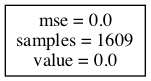

In [41]:
decision_tree_2=tree.DecisionTreeRegressor(min_samples_split=.025)
decision_tree_2.fit(X2,Y2)
pred2=decision_tree_2.predict(X2)
print('Strong learner R^2: {}'.format(decision_tree_2.score(X2,Y2))) 
dot_data=tree.export_graphviz(decision_tree_2, out_file=None,
                                feature_names=["Open","High","Low","Close","Volume","Market","Avg."],  
                                filled=True) 
graph=pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

Overall, the results of our Decision Tree model is disappointing; Bitcoin, Ethereum and Ripple had R^2 values of 0.001,0.01,and -0.0008 respectively. Its relative inability to explain the variability in Projection columns makes this model a lost cause. We will finally take a look at Random Forest Regression. Please refer to Pt. 2 of the Supervised Learning Capstone. 